<a href="https://colab.research.google.com/github/Ibsen-Gomes/Deep_learning_breast_cancer_binary_classification/blob/main/Deep_learning_breast_cancer_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 3)

#Using the best Hyperparameters found in the colab: Deep_learning_PyTorch_crossV_dropout_tuning.ipynb

### Libraries:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

### PyTorch package import:

In [2]:
import torch
torch.__version__

'2.0.1+cu118'

In [3]:
import torch.nn as nn

### Load data

In [4]:
np.random.seed(42)
torch.manual_seed(42)

In [5]:
previsores = pd.read_csv('/content/drive/MyDrive/Deep_learning/entradas_breast.csv')
classe = pd.read_csv('/content/drive/MyDrive/Deep_learning/saidas_breast.csv')

In [6]:
type(previsores)

pandas.core.frame.DataFrame

In [7]:
previsores.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,186.0000,275.0000,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,243.0000,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,173.00000
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,198.0000,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,205.0000,0.4000,0.1625,0.2364,0.07678


In [8]:
classe.head()

,0
0,0
1,0
2,0
3,0
4,0


In [9]:
np.unique(classe)

array([0, 1])

### Sample count for each label:

<Axes: xlabel='0', ylabel='count'>

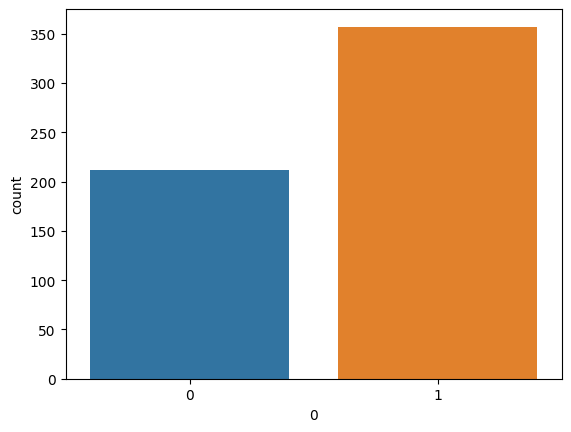

In [10]:
sns.countplot(x=classe['0'])

### Transformation into Tensors:

##### Essential for processing on GPUs

In [11]:
previsores = torch.tensor(np.array(previsores), dtype = torch.float)
classe = torch.tensor(np.array(classe), dtype = torch.float)

In [12]:
type(previsores)

torch.Tensor

#### Creation of a dataset with the union of predictors and classes:

In [13]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(previsores, classe), batch_size = 10, shuffle = True)

In [14]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

### Model building:

In [15]:
class classificador_torch(nn.Module):
    def __init__(self):
        super().__init__()

        # Contruindo a rede: 30 -> 16 -> 16 -> 1

        # 1) 30 -> 16:
        self.dense0 = nn.Linear(30, 8)
        torch.nn.init.normal_(self.dense0.weight, mean = 0.0, std= 0.05)

        # 2) 16 -> 16:
        self.dense1 = nn.Linear(8, 8)
        torch.nn.init.normal_(self.dense1.weight, mean = 0.0, std= 0.05)

        # 3) 16 -> 1:
        self.dense2 = nn.Linear(8, 1)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.output = nn.Sigmoid()

    def forward(self, X):

        X = self.dense0(X)
        X = self.activation(X)
        X = self.dropout(X)
        X = self.dense1(X)
        X = self.activation(X)
        X = self.dropout(X)
        X = self.dense2(X)
        X = self.output(X)

        return X

In [16]:
classificador = classificador_torch()

In [17]:
# Função de erro:

criterion = nn.BCELoss()
# Binary cross entropy (comparação entre previsão e gabarito)

In [18]:
# Otimizador

optimizer = torch.optim.Adam(classificador.parameters(),
                             lr = 0.001, # taxa de aprendizado
                             weight_decay = 0.0001) # decaimento dos pesos
                             # diminui lr com o passar das epocas

### Train step:

In [19]:
# Necessário um For para treinamento (diferente do TensorFLow ou Sklearn que tem um fit)
for epoch in range(200): # Em 1 epoca passando por 426 registros de 10 em 10 (batch) registros
  running_loss = 0. # Inicializar o acumulador do erro

  for data in train_loader: # train_loader = dados dividido em 10 em 10 registros

    inputs, labels = data # inputs=previsores e labels=classes
    optimizer.zero_grad() # zerar, pq em cada ajuste de peso é necessario calcular o gradiente separadamente

    outputs = classificador(inputs) #passando os inputs no modelo e gerando os outputs -> processo forward na rede (esqeurda p/ direita)
    # outputs-> classificador.forward(inputs)
    loss = criterion(outputs, labels) #calculo do erro entre labels reais e preditos
    loss.backward() #voltando e atualizando os pesos processo de backward na rede (direita p/ esquerda)
    optimizer.step() #atualização dos pesos usando o "Adam"

    running_loss += loss.item() #somatorio do erro
  print('Época %3d: perda %.5f' % (epoch+1, running_loss/len(train_loader)))


Época   1: perda 0.97008
Época   2: perda 0.58635
Época   3: perda 0.54363
Época   4: perda 0.53904
Época   5: perda 0.50976
Época   6: perda 0.47439
Época   7: perda 0.45982
Época   8: perda 0.45519
Época   9: perda 0.44725
Época  10: perda 0.40732
Época  11: perda 0.38278
Época  12: perda 0.36570
Época  13: perda 0.36539
Época  14: perda 0.37197
Época  15: perda 0.33728
Época  16: perda 0.35045
Época  17: perda 0.33362
Época  18: perda 0.30838
Época  19: perda 0.30996
Época  20: perda 0.27926
Época  21: perda 0.29213
Época  22: perda 0.29624
Época  23: perda 0.27357
Época  24: perda 0.28001
Época  25: perda 0.26190
Época  26: perda 0.28857
Época  27: perda 0.25516
Época  28: perda 0.25392
Época  29: perda 0.27343
Época  30: perda 0.26386
Época  31: perda 0.27594
Época  32: perda 0.25172
Época  33: perda 0.24124
Época  34: perda 0.24441
Época  35: perda 0.27407
Época  36: perda 0.25252
Época  37: perda 0.24498
Época  38: perda 0.25347
Época  39: perda 0.26146
Época  40: perda 0.25895


### Sorting a new patient record

In [20]:
novo = torch.tensor([[15.80, 8.34, 118, 900, 0.10, 0.26, 0.08, 0.134, 0.178,
                  0.20, 0.05, 1098, 0.87, 4500, 145.2, 0.005, 0.04, 0.05, 0.015,
                  0.03, 0.007, 23.15, 16.64, 178.5, 2018, 0.14, 0.185,
                  0.84, 158, 0.363]], dtype = torch.float)

In [21]:
classificador.eval() # .eval = significa que o classificador em modo avaliação


classificador_torch(
  (dense0): Linear(in_features=30, out_features=8, bias=True)
  (dense1): Linear(in_features=8, out_features=8, bias=True)
  (dense2): Linear(in_features=8, out_features=1, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (output): Sigmoid()
)

In [22]:
previsao = classificador(novo)

In [23]:
previsao = previsao = previsao.detach()
previsao = previsao.numpy()
previsao

array([[1.]], dtype=float32)

In [24]:
type(previsao)

numpy.ndarray

In [25]:
previsao = (previsao > 0.5)
previsao

array([[ True]])

### Save classifier weights

In [26]:
classificador.state_dict()

OrderedDict([('dense0.weight',
              tensor([[ 1.7191e-01,  3.1530e-01,  3.4512e-01,  4.5283e-02,  7.6804e-02,
                        2.7054e-02, -1.0811e-02,  7.6111e-01,  3.5106e-01, -5.0837e-01,
                       -2.5091e-02,  3.1908e-02, -6.7575e-03,  8.8070e-03,  8.6232e-03,
                        5.0790e-01,  5.4090e-01,  5.0852e-02, -4.1703e-01, -4.1383e-02,
                        3.4332e-01,  9.8579e-02,  1.8886e-01, -1.3166e-01, -2.8584e-01,
                        1.0251e-01, -2.2169e-01,  1.3207e-01,  8.7113e-02, -4.8013e-02],
                      [-1.0731e-04, -3.3308e-04,  7.2754e-03, -4.2624e-02,  2.7833e-39,
                       -7.5035e-05,  1.2376e-04,  1.3731e-39, -2.5132e-03, -8.3541e-05,
                       -5.7028e-03,  1.3194e-04, -7.4372e-04,  7.6252e-04,  3.5935e-40,
                       -2.3013e-39, -7.5227e-40,  3.3047e-39,  4.0950e-15, -1.6480e-39,
                       -6.1195e-05, -2.4310e-03, -1.9151e-02, -5.9335e-02,  3.6443e-04,


In [27]:
torch.save(classificador.state_dict(), '/content/drive/MyDrive/Deep_learning/checkpoint.pth')